<a href="https://colab.research.google.com/github/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/Taxi%20Cost%20Classification%20ANN%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taxi Cost Classification ANN with PyTorch** 🚖
Following tutorials and guidance by Pierian Data's "PyTorch for Deep Learning Bootcamp" on Udemy.

## **Aims for this notebook** 🎯

### **Dataset**
[Google Cloud NYC Taxi Fares Competition Dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)
* The New York City Taxi Fares dataset used in this notebook is from a Kaggle competition (originally with 55 million records which for download and training time purposes has been reduced to 120,000 records).

  * The data contained information about Taxi rides such as:
    * Pickup date
    * Pickup time
    * Latitude & longitude (GPS Coordinates)
    * Pickup location
    * Dropoff location
    * Number of passengers

### **Objective with Dataset**
* With the data available, using a Machine Learning model, I aim to accurately classify whether a Taxi ride is over or under $10.

  * Given the number of features, it will be crucial to discard the least relevant features during the Exploratory Data Analysis stage which will tell me which of these information categories in the dataset contribute most to accurate predictions.


# **Packages** 📦
* Import relevant packages for the project.

In [1]:
# import packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import time

# machine learning packages
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# settings
torch.set_printoptions(edgeitems=2)

# **1. Data Import & Data Analysis**

In [2]:
# import data
df = pd.read_csv('https://raw.githubusercontent.com/aaronhowellai/machine-learning-projects/main/datasets/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
# no missing values
df.count()

,0
pickup_datetime,120000
fare_amount,120000
fare_class,120000
pickup_longitude,120000
pickup_latitude,120000
dropoff_longitude,120000
dropoff_latitude,120000
passenger_count,120000


In [5]:
# describe fare amount feature
df['fare_amount'].describe()

,fare_amount
count,120000.000000
mean,10.040326
std,7.500134
min,2.500000
25%,5.700000
50%,7.700000
75%,11.300000
max,49.900000


In [11]:
df['fare_class'].value_counts()

,count
fare_class,
0,80000
1,40000


# **2. Feature Engineering**

## **2.1. Create a new distance travelled feature**
* Calculate distance travelled with GPS information with the Haversine formula

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
  """
  Calculates the haversine distance between 2 sets of GPS coordinates in df
  """
  r = 6371 # average radius of earth in kilometers

  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])

  delta_phi = np.radians( df[lat2] - df[lat1] )
  delta_lambda = np.radians( df[long2] - df[long1] )

  a = np.sin( (delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2 )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  d = r * c # in km

  return d

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
df['dist_km'] = haversine_distance(
    df,
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude'
    )

In [9]:
df['dist_km'].head()

,dist_km
0,2.126312
1,1.392307
2,3.326763
3,1.864129
4,7.231321


In [12]:
df['dist_km'].describe()

,dist_km
count,120000.000000
mean,3.322160
std,3.337005
min,0.010208
25%,1.316428
50%,2.237084
75%,4.034564
max,28.846384


### **Using Aggregate Functions to View Distance vs Fare Amounts**

In [13]:
df.groupby('dist_km')['fare_amount'].max()

,fare_amount
dist_km,
0.010208,49.57
0.010210,14.00
0.010250,2.90
0.010353,48.00
0.010477,49.57
...,...
26.781614,49.07
26.911172,49.57
26.976547,43.30


In [14]:
df.groupby('dist_km')['fare_amount'].mean()

,fare_amount
dist_km,
0.010208,49.57
0.010210,14.00
0.010250,2.90
0.010353,48.00
0.010477,49.57
...,...
26.781614,49.07
26.911172,49.57
26.976547,43.30


## **2.2. Create a new Date and Time feature**
* Derive useful Date and Time statistics

In [15]:
# the datetime feature is an object:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [16]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


* Hours, minutes and days can now be extracted

In [18]:
df['pickup_datetime'][0]

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [19]:
my_time = df['pickup_datetime'][0]

In [20]:
my_time.day

19

In [21]:
my_time.hour

8

### **Adjust Datetime Feature for April Daylight savings time**

In [22]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

### **Creating New Aggregate Features**
* These features well help to differentiate times of day in the most statistically descriptive and useful way.

In [23]:
df['Hour'] = df['EDTdate'].dt.hour

In [24]:
# Is the hour greater or less than 12
df['AM_or_PM'] = np.where(df['Hour']<12,'am','pm')

In [25]:
df.iloc[:,-4:].head()

,dist_km,EDTdate,Hour,AM_or_PM
0,2.126312,2010-04-19 04:17:56+00:00,4,am
1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,7.231321,2010-04-16 22:19:01+00:00,22,pm


In [26]:
df['Weekday'] = df['EDTdate'].dt.strftime('%a')

### **Categorical Features**

In [27]:
df.iloc[:,-5:].head()

,dist_km,EDTdate,Hour,AM_or_PM,Weekday
0,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


# **3. Categorify**

In [28]:
# check the full head again
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AM_or_PM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [29]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AM_or_PM', 'Weekday'],
      dtype='object')

In [30]:
# separate categorical variables
cat_cols = ['Hour','AM_or_PM','Weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [31]:
y_col = ['fare_class']

In [32]:
df.dtypes

,0
pickup_datetime,"datetime64[ns, UTC]"
fare_amount,float64
fare_class,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
dist_km,float64
EDTdate,"datetime64[ns, UTC]"


In [33]:
# change 'Hour' into categorical variable
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [34]:
df.dtypes

,0
pickup_datetime,"datetime64[ns, UTC]"
fare_amount,float64
fare_class,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
dist_km,float64
EDTdate,"datetime64[ns, UTC]"


In [35]:
df['Hour'].head()

,Hour
0,4
1,11
2,7
3,17
4,22


In [36]:
df['Hour'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 120000 entries, 0 to 119999
Series name: Hour
Non-Null Count   Dtype   
--------------   -----   
120000 non-null  category
dtypes: category(1)
memory usage: 117.8 KB


In [37]:
df['Hour'].values

[4, 11, 7, 17, 22, ..., 10, 6, 14, 4, 12]
Length: 120000
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [39]:
df['AM_or_PM'].values

['am', 'am', 'am', 'pm', 'pm', ..., 'am', 'am', 'pm', 'am', 'pm']
Length: 120000
Categories (2, object): ['am', 'pm']

In [40]:
df['Weekday'].values

['Mon', 'Sat', 'Sat', 'Sun', 'Fri', ..., 'Sun', 'Fri', 'Sun', 'Tue', 'Sat']
Length: 120000
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [41]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [42]:
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [43]:
# converting numpy arrays to stack
hr = df['Hour'].cat.codes.values
ampm = df['AM_or_PM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [44]:
# list comprehension method
# cats = np.stack([df[cols].cat.codes.values for col in cat_cols], 1)

In [45]:
cats = np.stack([hr, ampm, wkdy],axis=1)

In [59]:
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [47]:
# convert numpy array to tensor
cats = torch.tensor(cats,dtype=torch.int64)

In [48]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)

In [49]:
conts = torch.tensor(conts,dtype=torch.float)

In [50]:
y = torch.tensor(df[y_col].values).flatten()

In [52]:
y[:5]

tensor([0, 0, 1, 0, 1])

In [53]:
y.shape

torch.Size([120000])

In [54]:
cats.shape

torch.Size([120000, 3])

In [55]:
conts.shape

torch.Size([120000, 6])

## **3.2 Set embedding size**

In [60]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50,(size+1)//2)) for size in cat_szs]

In [61]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

# **4. Tabular Model**
* Use a Tabular Data model class to work with both categorical data and continuous data (floating points).
  * Define a model based on the number of continuous columns (given by `conts.shape[1]`) + the number of categorical columns and their embeddings (given by `len(emb_szs)` and `emb_szs` respectively).
  * The output would either be a regression (single float value) or a classification (a group of bins and their softmax values).

In [63]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [64]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [65]:
class TabularModel(nn.Module):

  def __init__(self, emb_szs, n_cont, out_sz,layers, p=0.5):
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerlist = []
    n_emb = sum([nf for ni,nf in emb_szs])
    n_in = n_emb + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i
    layerlist.append(nn.Linear(layers[-1],out_sz))

    self.layers = nn.Sequential(*layerlist)

  def forward(self,x_cat,x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)
    x = self.layers(x)
    return x

# **5. Define Loss Function Optimizer for Tabular Model**
* Add a loss function (function to measure model's error rates during training) and an optimizer (optimisation algorithm for minimising the loss function which finds optimal weights and biases)

In [66]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4)

In [67]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# **6. Perform Train/test split**

In [69]:
# data is shuffled already
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [70]:
[print(len(item)) for item in [cat_train,cat_test]]

48000
12000


[None, None]

# **7. Perform Model Training**

### **Track how long training time takes**

In [74]:
start_time = time.time()
epochs = 300
losses = []

for i in range(epochs):
  i+=1
  y_pred = model(cat_train,con_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss)

  if i%25==1:
    print(f'epoch: {i:3}, loss: {loss.item():10.8f}')

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


duration = time.time() - start_time
print(f'epoch: {i:3}, loss: {loss.item():10.8f}') # print the last line
print(f'Training took {duration/60} minutes')

epoch:   1, loss: 0.23457877
epoch:  26, loss: 0.23608817
epoch:  51, loss: 0.23351559
epoch:  76, loss: 0.23410676
epoch: 101, loss: 0.23323087
epoch: 126, loss: 0.23205009
epoch: 151, loss: 0.23058458
epoch: 176, loss: 0.23162039
epoch: 201, loss: 0.23060581
epoch: 226, loss: 0.22922154
epoch: 251, loss: 0.22893901
epoch: 276, loss: 0.22754407
epoch: 300, loss: 0.22697419
Training took 2.4227354447046916 minutes


## **Plot the Gradient Descent**

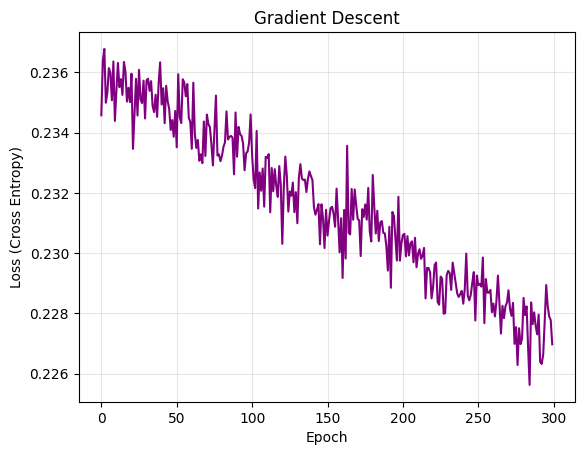

In [77]:
# convert losses to a numpy array
np_losses = [loss.detach().cpu().numpy() for loss in losses]
plt.plot(range(epochs),np_losses,color='purple')
plt.title('Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.grid(alpha=.3)
plt.show()

# **8. Evaluate The Model on Test Set**
* On average, the model predictions are $\pm$ $3.65 per price prediction.

In [83]:
with torch.no_grad():
  y_val = model(cat_test, con_test)
  loss = criterion(y_val,y_test)
print(f'CE Loss: {loss.item():.8f}')

CE Loss: 0.24000233


## **Difference Between Predictions and True Values**
* First 50 predicted values.

In [86]:
rows = 50
correct = 0
print(f"{'MODEL OUTPUT':26} ARGMAX  Y_TEST")
for i in range(50):
  print(f'{str(y_val[i]):26} {y_val[i].argmax():^7} {y_test[i]:^7}')
  if y_val[i].argmax().item() == y_test[i]:
    correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 0.9506, -1.4648])    0       0   
tensor([-2.7910,  2.7486])    1       0   
tensor([ 3.6893, -1.3930])    0       0   
tensor([0.3896, 0.9572])      1       1   
tensor([ 2.1338, -1.3983])    0       0   
tensor([ 2.3723, -1.8639])    0       0   
tensor([ 3.7695, -0.4543])    0       0   
tensor([-3.4529,  1.8997])    1       1   
tensor([ 2.2770, -0.9298])    0       0   
tensor([-0.6312,  0.1935])    1       1   
tensor([ 2.4755, -2.7350])    0       0   
tensor([ 2.8248, -1.8420])    0       0   
tensor([ 2.3073, -1.3998])    0       0   
tensor([-0.7008,  1.0964])    1       1   
tensor([ 2.1383, -2.2454])    0       0   
tensor([-2.6247,  1.5678])    1       1   
tensor([ 3.4282, -0.6933])    0       1   
tensor([ 2.4548, -2.2128])    0       0   
tensor([ 1.0629, -1.6082])    0       0   
tensor([ 3.2122, -1.4607])    0       0   
tensor([-1.1112,  1.0053])    1       1   
tensor([-0.8046,  0.9507])    1       1   
tensor([-2.2

## **Save The Model**

In [87]:
if len(losses) == epochs:
  torch.save(model.state_dict(),'TaxiModelClss.pt')
else:
  print('Model has not been trained. Consider loading a trained model instead')